In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta 
import json
import pickle
import time

import matplotlib.pyplot as plt
# or uncomment the function  find_walkings()
# import find_walkings 

In [2]:
!python --version

Python 3.10.8


# ETL

## Data extraction (loading from a file)

In [3]:
import os, fnmatch

def find(pattern, path): # match a pattern
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                print(f'{name}\t{root}')                
                result.append(os.path.join(root, name))
    return result 

In [4]:
!ls

Ig Sor.zip
Ig Sor_old.zip
README.md
Welltory - Data Analyst 11.22 - Test.docx
__pycache__
data_for_test.csv
find_walkings.py
find_walkings_old.py
requirements.txt
walkings.ipynb
walkings.json
walkings_old.ipynb
walkings_old.json


In [5]:
path = r'\\che-ds\CS_IgSor\GIT_syno\Welltory'   
res = find('*.csv', path )

In [6]:
# df = pd.read_csv("/content/data_for_test.csv", dtype={'steps':np.int16, 'time_offset':np.int16})
# df = pd.read_csv('\\\\che-ds\\CS_IgSor\\GIT_syno\\Welltory\\data_for_test.csv', dtype={'steps':np.int16, 'time_offset':np.int16})
df = pd.read_csv('data_for_test.csv', dtype={'steps':np.int16, 'time_offset':np.int16})

## Transformations

### Nones

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time_start_local  9827 non-null   object
 1   time_end_local    9827 non-null   object
 2   time_offset       9827 non-null   int16 
 3   steps             9827 non-null   int16 
dtypes: int16(2), object(2)
memory usage: 192.1+ KB


9827 rows.No nulls. So good so far..

In [8]:
df.head()

,time_start_local,time_end_local,time_offset,steps
0,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
1,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
2,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
3,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
4,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6


First of all lets sort the data

In [9]:
df.sort_values(by='time_start_local', inplace = True)

### Anomalies

Check sequences order

In [10]:
df[df.time_start_local > df.time_end_local]

,time_start_local,time_end_local,time_offset,steps
3,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
4,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
8,2022-03-19 08:26:05,2022-03-19 08:25:34,3600,13
12,2022-03-19 12:18:52,2022-03-19 12:18:34,3600,38
15,2022-03-19 12:28:14,2022-03-19 12:18:55,3600,19
...,...,...,...,...
9602,2022-04-19 18:36:07,2022-04-19 18:35:28,7200,11
9605,2022-04-19 19:00:55,2022-04-19 19:00:29,7200,31
9606,2022-04-19 19:00:55,2022-04-19 19:00:29,7200,31
9631,2022-04-19 22:06:41,2022-04-19 22:06:36,7200,8


We have 630 rows where time_start_local > df.time_end_local.

Lets change the order of fields

Focus on row[ 3 ] 

In [11]:
df.loc[3]

time_start_local    2022-03-19 04:52:55
time_end_local      2022-03-19 04:52:50
time_offset                        3600
steps                                 6
Name: 3, dtype: object

In [12]:
# change values between columns   'time_start_local' <--> 'time_end_local'
df[['time_start_local','time_end_local']] = \
df[['time_end_local','time_start_local']]\
    .where(df['time_start_local'] > df['time_end_local'], \
          df[['time_start_local','time_end_local']].values  )
df.reset_index(drop=True, inplace=True)

In [13]:
df.loc[3]

time_start_local    2022-03-19 04:52:50
time_end_local      2022-03-19 04:52:55
time_offset                        3600
steps                                 6
Name: 3, dtype: object

it's OK now

How data distribution looks like?

<AxesSubplot: >

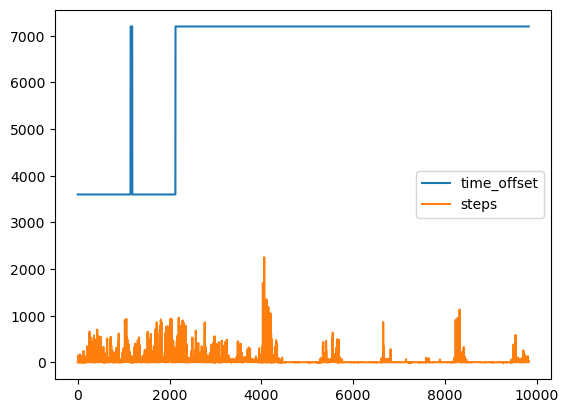

In [14]:
df.plot()

Our client moved over time zones. Lets go deeper here

In [15]:
# let's locate rows  where time_shift values changed
offset = df.time_offset 

In [16]:
# cast strings to datetime
df['time_start_local']= pd.to_datetime(df['time_start_local'])
df['time_end_local']= pd.to_datetime(df['time_end_local'])

In [17]:
# find  changing points in TZ intervals
tz_list = [0]
last_offset = offset[0]

for i, j  in enumerate(offset):

    if j != last_offset:
        tz_list.extend([i-1,i]) 
        # tz_list.extend([i]) 
        last_offset = j

tz_list.append(len(offset)-1)
tz_list

[0, 1149, 1150, 1186, 1187, 2127, 2128, 9826]

In [18]:
dftz = df.loc[tz_list] # filter by mask
dftz = dftz.diff()   # calc difference 
# dftz.loc[dftz.time_start_local < timedelta(hours = 12*30) ] # less than 5 hr 

In [19]:
dftz

,time_start_local,time_end_local,time_offset,steps
0,NaT,NaT,NaN,NaN
1149,7 days 21:14:40,7 days 21:15:09,0.0,17.0
1150,0 days 09:29:37,0 days 09:29:27,3600.0,13.0
1186,0 days 15:13:12,0 days 15:12:53,0.0,-30.0
1187,0 days 00:16:02,0 days 00:16:03,-3600.0,22.0
2127,3 days 22:49:21,3 days 22:49:54,0.0,8.0
2128,0 days 03:48:56,0 days 03:48:38,3600.0,-8.0
9826,18 days 20:30:13,18 days 20:29:58,0.0,-8.0


Intervals duration seems as normal. 

### Duplicates

In [20]:
mask = df.duplicated(keep=False) 
print(f"Duplicates : {mask.sum()}")

Duplicates : 4742


Lets take a closer look

In [21]:
df[mask].sort_values(by='time_start_local')

,time_start_local,time_end_local,time_offset,steps
0,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
1,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
2,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
3,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
4,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
...,...,...,...,...
9819,2022-04-19 22:18:22,2022-04-19 22:18:29,7200,15
9821,2022-04-19 22:30:49,2022-04-19 22:30:51,7200,8
9822,2022-04-19 22:30:49,2022-04-19 22:30:51,7200,8
9825,2022-04-19 22:43:59,2022-04-19 22:44:02,7200,16


Obiously it is a duplicated data. Let's drop it down

In [22]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
df.shape

(7327, 4)

Data is ready for arrangement

## Load

This Function could be imported from  find_walkings.py

In [28]:
def benchmark( func  ): 
    
    
    def wrapper(*args, **kwargs):    
        start = time.time()
        return_value =  func(*args, **kwargs) #, **kwargs
        end = time.time()
        print(f'[*] Execution time: {round(end-start,1)} s')
        return return_value 
    return wrapper


# @benchmark
def find_walkings(df, pace_min = 0.5, pace_max = 2, min_session = 300, max_pause = 15):
    '''
    Return a dictionary with a structure as follows:
        
    {
        "<day yyyy-mm-dd>": [  # list of walkings had taken that day
            {
                "start": "<yyyy-mm-dd HH:MM:SS>”,
                "end": "<yyyy-mm-dd HH:MM:SS>",
                "steps": <int>
            },
            …
        ]
    }

        Parameters
        ----------
        pace_min : Minimum pace rate during walking (steps per second).
        pace_max : Maximum pace rate during walking (steps per second).
        min_session: Minimum time to consider the session as a single 
                    walking activity (in seconds).
        max_pause: Maximum pause between records to merge into
                   a single walking activity (in seconds).

        Returns
        -------
        Dictionary.

        Output dictionary is written as a byte stream using python "pickle" library 
        to "walkings.json" file to default local folder.


    '''
    
    dateformat = '%Y-%m-%d %H:%M:%S'    
    walkings = {}
    day_list = []
    pause = 0
    next_r = 0

    for r in range(len(df)):

        # skip rows we have already read (if next_r > r)
        if next_r == r:

            # merge intervals with acceptable gaps ( < max_pause )

            # current row duration (interval)
            t_int = (df['time_end_local'].loc[r] - df['time_start_local'].loc[r])\
                    .total_seconds()
            steps = df['steps'].loc[r]

            # lookup for next row
            next_r = r + 1
            while next_r < len(df):
                
                # pause between rows (intervals)
                pause = (df['time_start_local'].loc[next_r] - \
                            df['time_end_local'].loc[next_r-1]).total_seconds()
                
                # if next interval starts before previous ends
                if pause < 0:
                    break

                # if pause is acceptable
                if  pause  < max_pause:
                    #  print(f'row:{r}  next_r:{next_r} pause:{pause}  t_int:{t_int}   steps:{steps}')

                    # new interval value 
                    t_int = (df['time_end_local'].loc[next_r] - df['time_start_local']\
                             .loc[r]).total_seconds()  
                    steps += df['steps'].loc[next_r]
                else:
                    
                    break
                
                next_r += 1


            # we have a merged data now
            

            if t_int >= min_session and  pace_min < steps/t_int < pace_max:

                                  
                current_day = df['time_start_local'].loc[r].strftime("%Y-%m-%d")

                # test for a DAY key
                if current_day not in walkings:

                    day_list = []
                    walkings.setdefault(current_day)
                    walkings[current_day] = day_list

                start = df['time_start_local'].loc[r].strftime(dateformat)

                # !!! next_r-1 index
                end = df['time_end_local'].loc[next_r-1].strftime(dateformat)

                walkings[current_day].append(
                                        {'start':start,
                                        'end':end,
                                        'steps':steps,
                                        # 'pace': round(steps / t_int, 1)
                                        }
                                        )

    return walkings

# THE dictionary

In [29]:
# define the outer function (if we run outer 'find_walkings.py')
# find_walkings = find_walkings.find_walkings

In [30]:
walkings = find_walkings(df, pace_min = 0.5, pace_max = 2, min_session = 300, max_pause = 15)

In [31]:
# write as bytes stream
with open('walkings.json', 'wb') as f:
    pickle.dump(walkings, f)

In [32]:
len(walkings)

26

In [33]:
# write as bytes stream
with open('walkings.json', 'wb') as f:
    pickle.dump(walkings, f)
f.close()  

# Evaluation

In [34]:
# test a data format
with open('walkings.json', 'rb') as f:
    dict_ = pickle.load(f)

type(dict_)

dict

In [35]:
len(dict_)

26

#### `Final result`

In [36]:
dict_['2022-03-29']

[{'start': '2022-03-29 11:53:39', 'end': '2022-03-29 11:59:30', 'steps': 245},
 {'start': '2022-03-29 11:59:56', 'end': '2022-03-29 12:06:04', 'steps': 191},
 {'start': '2022-03-29 14:03:50', 'end': '2022-03-29 14:20:37', 'steps': 617},
 {'start': '2022-03-29 14:22:48', 'end': '2022-03-29 14:31:07', 'steps': 260},
 {'start': '2022-03-29 14:41:03', 'end': '2022-03-29 14:46:04', 'steps': 239},
 {'start': '2022-03-29 14:46:20', 'end': '2022-03-29 14:53:05', 'steps': 214},
 {'start': '2022-03-29 17:58:31', 'end': '2022-03-29 18:09:40', 'steps': 490},
 {'start': '2022-03-29 19:17:07', 'end': '2022-03-29 19:27:18', 'steps': 674},
 {'start': '2022-03-29 23:12:13', 'end': '2022-03-29 23:30:08', 'steps': 1210}]